# Setup

In [1]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

# do PCA (and projective PCA?)
# todo: for each name look at its PCA (make a colored graph for different components?)
# train projection from PCA space to classifier space?
    
from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)

/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


# Gather Data

This will take a long time

In [4]:
# pip install git+https://github.com/Phylliida/MambaLens.git
# pip install git+https://github.com/Phylliida/ACDC.git
from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset
from mamba_lens.input_dependent_hooks import clean_hooks
from acdc import accuracy_metric
from acdc import ACDCEvalData
from acdc import get_pad_token
import itertools
import copy
from collections import defaultdict
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from tqdm import tqdm

seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

templates = ABC_TEMPLATES

model_kwargs = {
    "fast_ssm": True,
    "fast_conv": False,
}
patching_formats = list(get_all_single_name_abc_patching_formats())
all_important_layers = defaultdict(lambda: defaultdict(lambda: []))
scores = torch.zeros([len(templates), len(patching_formats)])
template_to_i = dict([(t,i) for (i,t) in enumerate(templates)])
patching_to_i = dict([(t,i) for (i,t) in enumerate(patching_formats)])

num_patching_pairs = 200
limited_layers = list(range(model.cfg.n_layers))

def patch_layer_hook(
    h: Float[torch.Tensor, "B E N"],
    hook: HookPoint,
) -> Float[torch.Tensor, "B E N"]:
    # patch in corrupted (they come in pairs)
    for i in range(0, h.size()[0], 2):
        h[i] = h[i+1]
    return h

def hooks_to_remove_token_cross_talk(layers):
    # remove conv cross talk
    hooks = []
    
    for layer in layers:
        L = data.data.size()[1]
        hooks.append((f"blocks.{layer}.hook_conv", patch_layer_hook))
        #for l in range(L): # don't need this because it's downstream
        #    hooks.append((f"blocks.{layer}.hook_h.{l}", patch_layer_hook))
    return hooks

for template, patching_format in itertools.product(templates, patching_formats):
    
    data = generate_dataset(model=model,
                      data_generator=ioi_data_generator,
                      num_patching_pairs=num_patching_pairs,
                      seed=seed,
                      valid_seed=valid_seed,
                      constrain_to_answers=constrain_to_answers,
                      has_symmetric_patching=has_symmetric_patching, 
                      varying_data_lengths=True,
                      templates=[template],
                      patching_formats=[patching_format])
    
    clean_hooks(model)
    def top_is_correct_metric(data: ACDCEvalData):
        return data.patched.top_is_correct
    #limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
    from functools import partial
    def wrap_run_with_hooks(model, fwd_hooks, bwd_hooks=[], **kwargs):
        '''
        Makes a fake object that acts like model
        but when you call it it'll actually call run_with_hooks with the provided hooks
        '''
        def wrapper(input, fwd_hooks, bwd_hooks):
            #print(f"running model with {len(fwd_hooks)} fwd hooks and {len(bwd_hooks)} bwd hooks")
            return model.run_with_hooks(input, only_use_these_layers=limited_layers, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks, **kwargs)
        wrapper_with_hooks = partial(wrapper, fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks)
        wrapper_with_hooks.tokenizer = model.tokenizer
        wrapper_with_hooks.cfg = model.cfg
        return wrapper_with_hooks

    def eval_layers(model, layers_to_patch):
        model_wrapped = wrap_run_with_hooks(model, fwd_hooks=hooks_to_remove_token_cross_talk(layers=layers_to_patch), **model_kwargs)        
        top_is_correct = data.eval(model=model_wrapped, batch_size=100, metric=top_is_correct_metric)
        accuracy = top_is_correct.sum().item()/top_is_correct.size()[0]
        return accuracy

    important_layers = []
    layers_patching = copy.deepcopy(limited_layers)
    while len(layers_patching) > 0:
        baseline_acc = eval_layers(model, layers_to_patch=layers_patching)
        print("baseline", baseline_acc)
        accuracies = []
        for layer in tqdm(layers_patching):
            layers_except = copy.deepcopy(layers_patching)
            layers_except.remove(layer)
            acc_if_not_patching = eval_layers(model, layers_to_patch=layers_except)
            accuracies.append(acc_if_not_patching)
        inds = torch.argsort(-torch.tensor(accuracies))
        # the highest accuracy is the change we want to do
        print(f"sorted", [(layers_patching[i], accuracies[i]) for i in inds])
        important_layer = layers_patching[inds[0]]
        print(f"not patching layer {important_layer}")
        layers_patching.remove(important_layer)
        important_layers.append((accuracies[inds[0]], important_layer))
        if accuracies[inds[0]] > 0.90:
            break
    print(f"template: {template}")
    print(f"patching format:")
    print(patching_format)
    print(f"important layers", important_layers)
    all_important_layers[template_to_i[template]][patching_to_i[patching_format]] = important_layers
    

baseline 0.0


100%|███████████████████████████████████████████████████████████████████████████████████| 48/48 [02:54<00:00,  3.63s/it]


sorted [(39, 0.75), (36, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (24, 0.0), (37, 0.0), (38, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.0), (46, 0.0), (47, 0.0), (12, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (0, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0)]
not patching layer 39
baseline 0.75


100%|███████████████████████████████████████████████████████████████████████████████████| 47/47 [02:52<00:00,  3.66s/it]


sorted [(35, 0.8), (40, 0.8), (15, 0.79), (47, 0.7825), (26, 0.7775), (37, 0.7775), (14, 0.7775), (22, 0.7775), (27, 0.775), (43, 0.7725), (0, 0.7725), (36, 0.77), (13, 0.77), (19, 0.77), (25, 0.7675), (7, 0.765), (16, 0.765), (30, 0.7625), (32, 0.7625), (24, 0.7625), (18, 0.7625), (2, 0.7625), (38, 0.7625), (21, 0.76), (9, 0.76), (17, 0.7575), (10, 0.7575), (8, 0.7575), (31, 0.7575), (4, 0.7575), (23, 0.755), (20, 0.755), (29, 0.7525), (33, 0.7525), (11, 0.7525), (46, 0.7525), (28, 0.75), (42, 0.75), (3, 0.75), (45, 0.75), (34, 0.7475), (12, 0.7475), (5, 0.7475), (1, 0.7475), (44, 0.745), (6, 0.7375), (41, 0.73)]
not patching layer 35
baseline 0.8


100%|███████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.67s/it]


sorted [(15, 0.8375), (40, 0.8225), (47, 0.82), (19, 0.82), (23, 0.815), (37, 0.815), (2, 0.815), (31, 0.8125), (22, 0.81), (26, 0.8075), (1, 0.8075), (43, 0.8075), (36, 0.8075), (32, 0.8075), (25, 0.8075), (0, 0.8075), (18, 0.8075), (13, 0.8075), (46, 0.805), (38, 0.805), (14, 0.805), (4, 0.8025), (24, 0.8025), (3, 0.8025), (27, 0.8025), (30, 0.8025), (16, 0.8), (7, 0.8), (45, 0.8), (33, 0.8), (6, 0.8), (21, 0.8), (20, 0.8), (17, 0.8), (29, 0.7975), (8, 0.7975), (44, 0.7975), (12, 0.795), (11, 0.795), (34, 0.795), (9, 0.795), (28, 0.7925), (10, 0.7925), (42, 0.79), (5, 0.7875), (41, 0.78)]
not patching layer 15
baseline 0.8375


100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:45<00:00,  3.67s/it]


sorted [(40, 0.8725), (19, 0.865), (31, 0.8625), (47, 0.86), (22, 0.855), (0, 0.8525), (23, 0.85), (2, 0.85), (38, 0.8475), (27, 0.8475), (24, 0.8475), (43, 0.845), (9, 0.845), (28, 0.845), (25, 0.845), (8, 0.8425), (26, 0.8425), (21, 0.8425), (14, 0.8425), (32, 0.84), (1, 0.84), (46, 0.84), (36, 0.84), (12, 0.84), (5, 0.84), (20, 0.84), (17, 0.84), (37, 0.8375), (18, 0.8375), (11, 0.8375), (13, 0.8375), (33, 0.8375), (30, 0.8375), (29, 0.8375), (6, 0.835), (34, 0.835), (45, 0.835), (4, 0.835), (16, 0.8325), (10, 0.8325), (42, 0.8325), (7, 0.8325), (3, 0.83), (44, 0.825), (41, 0.815)]
not patching layer 40
baseline 0.8725


100%|███████████████████████████████████████████████████████████████████████████████████| 44/44 [02:41<00:00,  3.67s/it]

sorted [(19, 0.9125), (0, 0.905), (47, 0.9025), (31, 0.8975), (28, 0.8925), (2, 0.89), (23, 0.885), (27, 0.885), (13, 0.885), (9, 0.885), (18, 0.8825), (37, 0.8825), (43, 0.8825), (46, 0.88), (34, 0.88), (20, 0.88), (30, 0.88), (38, 0.8775), (14, 0.8775), (36, 0.8775), (21, 0.8775), (24, 0.8775), (5, 0.875), (32, 0.875), (29, 0.875), (1, 0.875), (25, 0.875), (11, 0.875), (22, 0.875), (7, 0.875), (26, 0.875), (10, 0.8725), (6, 0.8725), (33, 0.8725), (17, 0.8725), (8, 0.8725), (45, 0.8725), (12, 0.8725), (16, 0.87), (44, 0.87), (42, 0.87), (3, 0.87), (4, 0.87), (41, 0.85)]
not patching layer 19
template: Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
patching format:
CAB AB C
DAB AB D
important layers [(0.75, 39), (0.8, 35), (0.8375, 15), (0.8725, 40), (0.9125, 19)]


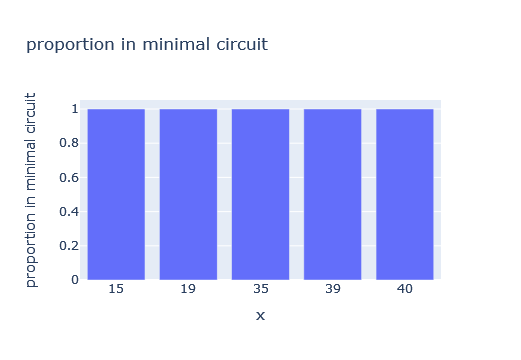

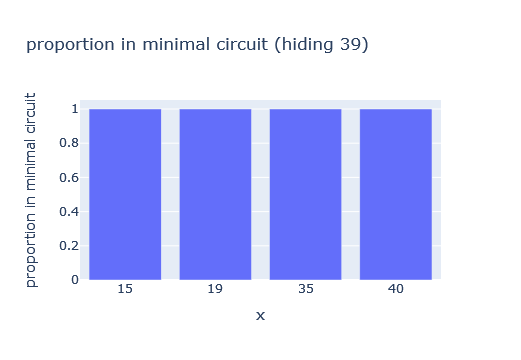

In [9]:

layer_counts = defaultdict(lambda: 0)
res = {}
for k,v in all_important_layers.items():
    res[k] = list(v.items())
total = 0
for template_i, values in res.items():
    for patching_i, scores in values:
        total += 1
        for score, layer in scores:
            layer_counts[layer] += 1

def bar_chart(data, x_labels, y_label, title, font_size=None):
    import pandas as pd
    import plotly.express as px
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))    
    fig.show()

# sort by layer index
layer_counts = list(layer_counts.items())
layer_counts.sort(key=lambda x: x[0])

bar_chart(torch.tensor([count/float(total) for (layer,count) in layer_counts]), x_labels=[str(layer) for (layer, count) in layer_counts], y_label='proportion in minimal circuit', title='proportion in minimal circuit')
bar_chart(torch.tensor([count/float(total) for (layer,count) in layer_counts if not layer == 39]), x_labels=[str(layer) for (layer,count) in layer_counts if not layer == 39], y_label='proportion in minimal circuit', title='proportion in minimal circuit (hiding 39)')


In [ ]:
1+1